<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Scale-heights-for-typical-atmospheric-soundings" data-toc-modified-id="Scale-heights-for-typical-atmospheric-soundings-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Scale heights for typical atmospheric soundings</a></span><ul class="toc-item"><li><span><a href="#Plot-McClatchey's-US-Standard-Atmospheres" data-toc-modified-id="Plot-McClatchey's-US-Standard-Atmospheres-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Plot McClatchey's US Standard Atmospheres</a></span></li><li><span><a href="#Calculating-scale-heights" data-toc-modified-id="Calculating-scale-heights-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Calculating scale heights</a></span><ul class="toc-item"><li><span><a href="#How-do-$\overline{H}$-and-$\overline{H_\rho}$-compare-for-the-tropical-sounding?" data-toc-modified-id="How-do-$\overline{H}$-and-$\overline{H_\rho}$-compare-for-the-tropical-sounding?-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>How do $\overline{H}$ and $\overline{H_\rho}$ compare for the tropical sounding?</a></span></li><li><span><a href="#How-well-do-these-average-values-represent-the-pressure-and-density-profiles?" data-toc-modified-id="How-well-do-these-average-values-represent-the-pressure-and-density-profiles?-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>How well do these average values represent the pressure and density profiles?</a></span></li></ul></li></ul></li></ul></div>

# Scale heights for typical atmospheric soundings

## Plot McClatchey's US Standard Atmospheres

In this section we're going to read soundings written as pandas dataframes.  A dataframe is a data structure adopted from R, which gives a spreadsheet-like view of the data, with columns referenced by name instead of index number.
There are a lot of nice aspects to dataframes, the only one we'll be using here is the ability to pull a column of data referenced by name.  Here's a  [short pandas tutorial](http://clouds.eos.ubc.ca/~phil/courses/atsc500/html_files/intro_to_pandas.html)

In [24]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticks
import urllib
import numpy as np

I've written an hdf5 file with 5 standard atmospheric soundings called soundings.h5:

In [25]:
data_download=True  ### set this to True if running for the first time
if data_download:
    urllib.request.urlretrieve("http://clouds.eos.ubc.ca/~phil/docs/atsc500/soundings.h5", 
                           "soundings.h5")

In [26]:
with pd.HDFStore('soundings.h5') as store:
    print(store.keys())

['/midsummer', '/midwinter', '/subsummer', '/subwinter', '/tropics']


We use these keys to get a dataframe with 6 columns, and 33 levels

In [27]:
with pd.HDFStore('soundings.h5') as store:
    df=store['tropics']
    print(len(df))
    print(df.columns)
    print(df['z'].values)

33
Index(['z', 'press', 'Temp', 'rmix', 'den', 'o3den'], dtype='object')
[      0.    1000.    2000.    3000.    4000.    5000.    6000.    7000.
    8000.    9000.   10000.   11000.   12000.   13000.   14000.   15000.
   16000.   17000.   18000.   19000.   20000.   21000.   22000.   23000.
   24000.   25000.   30000.   35000.   40000.   45000.   50000.   70000.
  100000.]


Read all soundings into a dictionary

In [28]:
sound_dict={}
with pd.HDFStore('soundings.h5') as store:
    the_names=store.keys()
    #
    # index from 1 to chop of the leading '/'
    #
    the_names=[a_name[1:] for a_name in the_names]
    for a_name in the_names:
        sound_dict[a_name]=store[a_name]

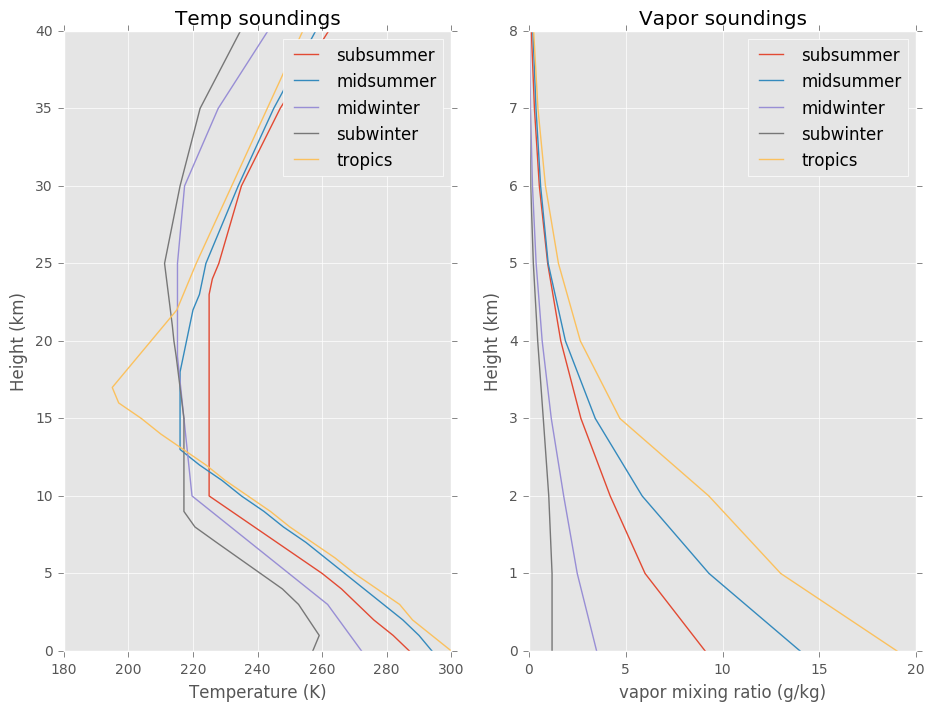

In [29]:
%matplotlib inline
plt.style.use('ggplot')
meters2km=1.e-3
plt.close('all')
fig,ax=plt.subplots(1,2,figsize=(11,8))
for a_name,df in sound_dict.items():
    ax[0].plot(df['Temp'],df['z']*meters2km,label=a_name)
    ax[0].set(ylim=(0,40),title='Temp soundings',ylabel='Height (km)',
       xlabel='Temperature (K)')

    ax[1].plot(df['rmix']*1.e3,df['z']*meters2km,label=a_name)
    ax[1].set(ylim=(0,8),title='Vapor soundings',ylabel='Height (km)',
       xlabel='vapor mixing ratio (g/kg)')
ax[0].legend()
ax[1].legend()

## Calculating scale heights

Here is equation 5 of the [hydrostatic balance notes](http://clouds.eos.ubc.ca/~phil/courses/atsc500/docs/hydro.pdf)

$$\frac{ 1}{\overline{H}} =  \overline{ \left ( \frac{1 }{H} \right )} = \frac{\int_{0 }^{z}\!\frac{1}{H} dz^\prime  }{z-0} $$

where

$$H=R_d T/g$$

and here is the Python code to do that integral:

In [30]:
g=9.8
Rd=287.
def calcScaleHeight(T,p,z):
    dz=np.diff(z)
    TLayer=(T[1:] + T[0:-1])/2.
    oneOverH=g/(Rd*TLayer)
    Zthick=z[-1] - z[0]
    oneOverHbar=np.sum(oneOverH*dz)/Zthick
    return oneOverHbar

Similarly, equation (10) of [hydrostatic balance notes](http://clouds.eos.ubc.ca/~phil/courses/atsc500/docs/hydro.pdf)
is:

$$\frac{d\rho }{\rho} = - \left ( \frac{1 }{H} + 
                   \frac{1 }{T} \frac{dT }{dz} \right ) dz \equiv - \frac{dz }{H_\rho} $$
                   
Which leads to 

$$\frac{ 1}{\overline{H_\rho}}  = \frac{\int_{0 }^{z}\!\left [ \frac{1}{H} + \frac{1 }{T} \frac{dT }{dz} \right ] dz^\prime  }{z-0} $$

and the following python function:


In [31]:
def calcDensHeight(T,p,z):
    """
       input:  T (K), p (pa), z(m)
       output: 
    """
    dz=np.diff(z)
    TLayer=(T[1:] + T[0:-1])/2.
    dTdz=np.diff(T)/np.diff(z)
    oneOverH=g/(Rd*TLayer) + (1/TLayer*dTdz)
    Zthick=z[-1] - z[0]
    oneOverHbar=np.sum(oneOverH*dz)/Zthick
    return oneOverHbar

### How do $\overline{H}$ and $\overline{H_\rho}$ compare for the tropical sounding?

In [32]:
sounding='tropics'
df=sound_dict[sounding]
z=df['z'].values
Temp=df['Temp'].values
press=df['press'].values

In [33]:
#
# limit calculation to bottom 10 km
#
hit=z<10000.
zL,pressL,TempL=(z[hit],press[hit],Temp[hit])
rhoL=pressL/(Rd*TempL)
Hbar= 1./calcScaleHeight(TempL,pressL,zL)
Hrho= 1./calcDensHeight(TempL,pressL,zL)
print("pressure scale height for the {} sounding is {:5.2f} km".format(sounding,Hbar*1.e-3))
print("density scale height for the {} is {:5.2f} km".format(sounding,Hrho*1.e-3))

pressure scale height for the tropics sounding is  7.96 km
density scale height for the tropics is  9.74 km


### How well do these average values represent the pressure and density profiles?

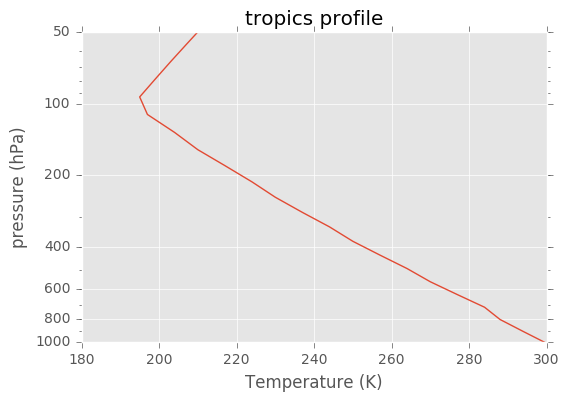

In [34]:
theFig,theAx=plt.subplots(1,1)
theAx.semilogy(Temp,press/100.)
theAx.invert_yaxis()
tickvals=[1000,800, 600, 400, 200, 100, 50,1]
theAx.set_yticks(tickvals)
majorFormatter = ticks.FormatStrFormatter('%d')
theAx.yaxis.set_major_formatter(majorFormatter)
theAx.set_yticklabels(tickvals)
theAx.set_ylim([1000.,50.])
theAx.set_title('{} profile'.format(sounding))
theAx.set_xlabel('Temperature (K)')
theAx.set_ylabel('pressure (hPa)')

Plot 

$$p(z) = p_0 \exp \left (-z/\overline{H} \right )$$

vs. the actual sounding p(T):

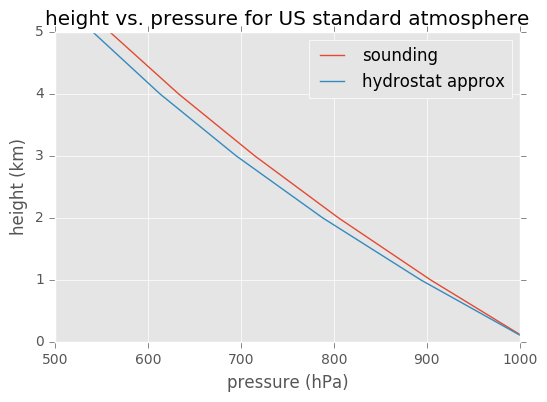

In [36]:
fig,theAx=plt.subplots(1,1)
hydroPress=pressL[0]*np.exp(-zL/Hbar)
theAx.plot(pressL/100.,zL/1000.,label='sounding')
theAx.plot(hydroPress/100.,zL/1000.,label='hydrostat approx')
theAx.set_title('height vs. pressure for US standard atmosphere')
theAx.set_xlabel('pressure (hPa)')
theAx.set_ylabel('height (km)')
theAx.set_xlim([500,1000])
theAx.set_ylim([0,5])
tickVals=[500, 600, 700, 800, 900, 1000]
theAx.set_xticks(tickVals)
theAx.set_xticklabels(tickVals)
theAx.legend(loc='best')

Plot 

$$\rho(z) = \rho_0 \exp \left (-z/\overline{H_\rho} \right )$$

vs. the actual sounding $\rho(T)$:

In [ ]:
fig,theAx=plt.subplots(1,1)
hydroDens=rhoL[0]*np.exp(-zL/Hrho1)
theAx.plot(rhoL,zL/1000.,label='sounding')
theAx.plot(hydroDens,zL/1000.,label='hydrostat approx')
theAx.set_title('height vs. density for US standard atmosphere')
theAx.set_xlabel('density ($kg\,m^{-3}$)')
theAx.set_ylabel('height (km)')
theAx.set_ylim([0,5])
theAx.legend(loc='best')